In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from stellargraph import StellarGraph

In [2]:
raw = pd.read_csv("TCGA_selected_features_213.csv")
raw = raw.drop_duplicates(subset = 'ID')

In [3]:
raw

,Symbol,Group,ID,LogFC,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,...,Tissue_Eye_Score,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing
0,PYCR1,P,5831,3.652931,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,...,5.75,0.733849,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849
1,TEDC2,P,80178,3.424342,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,FAM83A,P,84985,6.214945,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,...,0.29,0.140032,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000
3,IQGAP3,P,128239,3.517626,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,...,0.74,0.287367,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367
4,ADM2,P,79924,3.457656,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,...,0.27,0.205044,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,AGL,N,178,0.245273,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,...,4.20,0.337692,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692
3321,LRP5,N,4041,0.259900,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,...,11.70,0.557450,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450
3322,SPTY2D1,N,144108,0.154152,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,...,0.16,0.340003,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000
3323,DDX50,N,79009,0.132416,0.810994,0.711953,0.713423,0.711953,0.0,0.00000,...,0.80,0.711953,0.523447,1.23,0.711953,0.324751,1.14,0.711953,0.000000,0.000000


In [4]:
raw['Group'].value_counts()

P    1946
N    1379
Name: Group, dtype: int64

In [5]:
new_feature = raw.copy()

In [6]:
new_feature = new_feature[~new_feature['ID'].str.contains("ENSG")]

In [7]:
new_feature['ID'] = new_feature['ID'].astype('int')

In [8]:
new_feature=new_feature.drop({'LogFC'},axis = 1)

In [9]:
new_feature

,Symbol,Group,ID,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,...,Tissue_Eye_Score,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing
0,PYCR1,P,5831,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,0.939546,...,5.75,0.733849,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849
1,TEDC2,P,80178,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.563540,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,FAM83A,P,84985,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,1.208603,...,0.29,0.140032,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000
3,IQGAP3,P,128239,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,1.290103,...,0.74,0.287367,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367
4,ADM2,P,79924,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,0.000000,...,0.27,0.205044,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,AGL,N,178,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,0.000000,...,4.20,0.337692,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692
3321,LRP5,N,4041,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,1.162681,...,11.70,0.557450,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450
3322,SPTY2D1,N,144108,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,0.000000,...,0.16,0.340003,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000
3323,DDX50,N,79009,0.810994,0.711953,0.713423,0.711953,0.0,0.00000,0.000000,...,0.80,0.711953,0.523447,1.23,0.711953,0.324751,1.14,0.711953,0.000000,0.000000


In [10]:
all_genes = list(new_feature.ID)
Gene_Net = pd.read_csv("D:/PhD Y4/GeneDrug/Data/HuGFAN/HuGFAN_protein-coding gene functional association network.txt", sep = ',')
Gene_Net = Gene_Net.rename(columns={"Entrez Gene ID 1": "source", "Entrez Gene ID 2": "target","Spcc Score":"weight"})
all_genes = list(map(int,all_genes))
use_net = Gene_Net[(Gene_Net['source'].isin(all_genes)) & (Gene_Net['target'].isin(all_genes))]

In [11]:
data_feature = new_feature.drop({'Symbol'},axis = 1)
data_feature['Subject'] = 0
data_feature.loc[data_feature['Group'] == 'P','Subject'] = 'P'
data_feature.loc[data_feature['Group'] == 'N','Subject'] = 'N'
data_feature = data_feature.drop({'Group'},axis = 1)

In [12]:
data_feature

,ID,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,...,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing,Subject
0,5831,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,0.939546,0.733849,0.946866,...,0.733849,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849,P
1,80178,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.563540,0.716524,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,P
2,84985,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,1.208603,0.140032,0.000000,...,0.140032,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000,P
3,128239,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,1.290103,0.287367,0.000000,...,0.287367,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367,P
4,79924,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,0.000000,0.000000,0.599311,...,0.205044,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,178,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.337692,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692,N
3321,4041,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,1.162681,0.557450,1.203678,...,0.557450,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450,N
3322,144108,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.340003,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000,N
3323,79009,0.810994,0.711953,0.713423,0.711953,0.0,0.00000,0.000000,0.000000,0.000000,...,0.711953,0.523447,1.23,0.711953,0.324751,1.14,0.711953,0.000000,0.000000,N


In [13]:
data_feature = data_feature.set_index("ID")
data_feature

,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,Disease_ProstateCancer_Causing,...,Tissue_Eye_Causing,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing,Subject
ID,,,,,,,,,,,,,,,,,,,,,
5831,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,0.939546,0.733849,0.946866,0.733849,...,0.733849,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849,P
80178,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.563540,0.716524,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,P
84985,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,1.208603,0.140032,0.000000,0.000000,...,0.140032,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000,P
128239,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,1.290103,0.287367,0.000000,0.000000,...,0.287367,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367,P
79924,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,0.000000,0.000000,0.599311,0.205044,...,0.205044,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.337692,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692,N
4041,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,1.162681,0.557450,1.203678,0.557450,...,0.557450,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450,N
144108,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.340003,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000,N


In [14]:
data_one_hot_subject = pd.get_dummies(
    data_feature, columns=["Subject"]
)
data_one_hot_subject

,Disease_BreastCancer_NlogP,Disease_BreastCancer_Causing,Disease_ColorectalCancer_NlogP,Disease_ColorectalCancer_Causing,Disease_DengueHemorrhagicFever_NlogP,Disease_DiseasofMentalHealth_Causing,Disease_LungCancer_NlogP,Disease_LungCancer_Causing,Disease_ProstateCancer_NlogP,Disease_ProstateCancer_Causing,...,Tissue_Kidney_NlogP,Tissue_Kidney_Score,Tissue_Kidney_Causing,Tissue_Lung_NlogP,Tissue_Lung_Score,Tissue_Lung_Causing,Tissue_NeuralTube_NlogP,Tissue_NeuralTube_Causing,Subject_N,Subject_P
ID,,,,,,,,,,,,,,,,,,,,,
5831,0.584019,0.733849,0.960329,0.733849,0.0,0.00000,0.939546,0.733849,0.946866,0.733849,...,0.264728,0.69,0.733849,1.076297,4.12,0.733849,0.891897,0.733849,0,1
80178,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.563540,0.716524,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,1
84985,0.768521,0.140032,0.000000,0.000000,0.0,0.00000,1.208603,0.140032,0.000000,0.000000,...,0.000000,0.00,0.000000,0.779447,2.51,0.140032,0.000000,0.000000,0,1
128239,0.804759,0.287367,0.962978,0.287367,0.0,0.00000,1.290103,0.287367,0.000000,0.000000,...,0.427709,1.01,0.287367,0.652515,2.07,0.287367,0.792657,0.287367,0,1
79924,0.368886,0.205044,0.500375,0.205044,0.0,0.00000,0.000000,0.000000,0.599311,0.205044,...,1.011909,3.06,0.205044,0.377570,1.27,0.205044,0.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.351485,0.337692,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.977443,2.87,0.337692,0.567798,1.80,0.337692,0.971822,0.337692,1,0
4041,0.514616,0.557450,1.682435,0.557450,0.0,0.55745,1.162681,0.557450,1.203678,0.557450,...,2.763258,23.70,0.557450,0.987747,3.50,0.557450,0.971822,0.557450,1,0
144108,0.583236,0.340003,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.273619,0.70,0.340003,0.340907,1.18,0.340003,0.000000,0.000000,1,0


In [15]:
G = StellarGraph(data_one_hot_subject[list(data_one_hot_subject.columns)[:-2]], use_net)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3091, Edges: 31515

 Node types:
  default: [3091]
    Features: float32 vector, length 68
    Edge types: default-default->default

 Edge types:
    default-default->default: [31515]
        Weights: range=[0.997, 1], mean=0.999956, std=0.000294184
        Features: none


In [16]:
node_subjects = data_feature['Subject']

In [17]:
from sklearn import model_selection
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=2300, test_size=None, stratify=node_subjects,random_state=42
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=400, test_size=None, stratify=test_subjects,random_state=42
)



In [18]:
train_subjects

ID
84634     P
5083      P
64343     N
29968     P
253725    N
         ..
340654    P
22990     N
2206      P
81490     N
8370      P
Name: Subject, Length: 2300, dtype: object

In [19]:
val_subjects

ID
100874364    P
81628        N
112268124    N
7013         N
57470        N
            ..
51585        N
51601        N
22927        N
54726        N
56926        N
Name: Subject, Length: 400, dtype: object

In [20]:
test_subjects

ID
84451        N
1777         N
9748         N
6886         P
7547         P
            ..
105369758    P
23410        N
8220         N
128646       P
9917         N
Name: Subject, Length: 391, dtype: object

In [21]:
from collections import Counter

Counter(test_subjects)

Counter({'N': 173, 'P': 218})

In [22]:
target_encoding_1 = preprocessing.LabelEncoder()
target_encoding_2 = preprocessing.OneHotEncoder(sparse=False)

In [23]:
train_targets_temp = target_encoding_1.fit_transform(train_subjects)
train_targets = target_encoding_2.fit_transform(train_targets_temp.reshape(-1,1))

val_targets_temp = target_encoding_1.fit_transform(val_subjects)
val_targets = target_encoding_2.fit_transform(val_targets_temp.reshape(-1,1))

test_targets_temp = target_encoding_1.fit_transform(test_subjects)
test_targets = target_encoding_2.fit_transform(test_targets_temp.reshape(-1,1))
# val_targets = target_encoding.transform(val_subjects)
# test_targets = target_encoding.transform(test_subjects)

In [24]:
train_targets

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [25]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [26]:
train_subjects.index

Int64Index([ 84634,   5083,  64343,  29968, 253725,  51234,  79645, 133015,
              9354,  80274,
            ...
              5348, 160622,   1268, 116068,  11252, 340654,  22990,   2206,
             81490,   8370],
           dtype='int64', name='ID', length=2300)

In [27]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["tanh", "softmax"],
    attn_heads=5,
    generator=generator,
    in_dropout=0.2,
    attn_dropout=0.2,
    normalize=None,
)

In [28]:
x_inp, predictions = gat.in_out_tensors()

In [29]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=[tf.keras.metrics.AUC(name='auc',num_thresholds=1000, curve='ROC')],
)

c:\users\clement\appdata\local\programs\python\python37\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("final_tvt"):
    os.makedirs("final_tvt")
es_callback = EarlyStopping(
    monitor="val_auc", patience=50
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "final_tvt/best_model.h5", monitor="val_auc", save_best_only=True, save_weights_only=True
)

In [32]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 2s - loss: 1.3607 - auc: 0.4982 - val_loss: 0.7285 - val_auc: 0.5414 - 2s/epoch - 2s/step
Epoch 2/500
1/1 - 0s - loss: 0.7387 - auc: 0.5227 - val_loss: 0.8015 - val_auc: 0.5039 - 116ms/epoch - 116ms/step
Epoch 3/500
1/1 - 0s - loss: 0.7802 - auc: 0.5295 - val_loss: 0.9031 - val_auc: 0.5163 - 96ms/epoch - 96ms/step
Epoch 4/500
1/1 - 0s - loss: 0.9002 - auc: 0.4738 - val_loss: 0.8243 - val_auc: 0.5280 - 97ms/epoch - 97ms/step
Epoch 5/500
1/1 - 0s - loss: 0.8915 - auc: 0.5107 - val_loss: 0.7042 - val_auc: 0.5648 - 101ms/epoch - 101ms/step
Epoch 6/500
1/1 - 0s - loss: 0.7288 - auc: 0.5416 - val_loss: 0.6545 - val_auc: 0.6946 - 98ms/epoch - 98ms/step
Epoch 7/500
1/1 - 0s - loss: 0.6971 - auc: 0.5906 - val_loss: 0.6578 - val_auc: 0.6414 - 104ms/epoch - 104ms/step
Epoch 8/500
1/1 - 0s - loss: 0.6893 - auc: 0.6001 - val_loss: 0.6721 - val_auc: 0.6437 - 98ms/epoch - 98ms/step
Epoch 9/500
1/1 - 0s - loss: 0.7433 - auc: 0.5708 - val_loss: 0.6696 - val_auc: 0.6490 - 98ms/epoch - 

Epoch 74/500
1/1 - 0s - loss: 0.5419 - auc: 0.8017 - val_loss: 0.5210 - val_auc: 0.8229 - 96ms/epoch - 96ms/step
Epoch 75/500
1/1 - 0s - loss: 0.5430 - auc: 0.8044 - val_loss: 0.5011 - val_auc: 0.8393 - 94ms/epoch - 94ms/step
Epoch 76/500
1/1 - 0s - loss: 0.5435 - auc: 0.8024 - val_loss: 0.4860 - val_auc: 0.8550 - 90ms/epoch - 90ms/step
Epoch 77/500
1/1 - 0s - loss: 0.5245 - auc: 0.8161 - val_loss: 0.4828 - val_auc: 0.8581 - 91ms/epoch - 91ms/step
Epoch 78/500
1/1 - 0s - loss: 0.5344 - auc: 0.8136 - val_loss: 0.4826 - val_auc: 0.8564 - 98ms/epoch - 98ms/step
Epoch 79/500
1/1 - 0s - loss: 0.5132 - auc: 0.8270 - val_loss: 0.4911 - val_auc: 0.8461 - 99ms/epoch - 99ms/step
Epoch 80/500
1/1 - 0s - loss: 0.5259 - auc: 0.8177 - val_loss: 0.5026 - val_auc: 0.8364 - 94ms/epoch - 94ms/step
Epoch 81/500
1/1 - 0s - loss: 0.5296 - auc: 0.8129 - val_loss: 0.4934 - val_auc: 0.8436 - 95ms/epoch - 95ms/step
Epoch 82/500
1/1 - 0s - loss: 0.5161 - auc: 0.8278 - val_loss: 0.4827 - val_auc: 0.8536 - 96ms/e

1/1 - 0s - loss: 0.4695 - auc: 0.8609 - val_loss: 0.4421 - val_auc: 0.8749 - 96ms/epoch - 96ms/step
Epoch 147/500
1/1 - 0s - loss: 0.4797 - auc: 0.8522 - val_loss: 0.4478 - val_auc: 0.8709 - 93ms/epoch - 93ms/step
Epoch 148/500
1/1 - 0s - loss: 0.4744 - auc: 0.8567 - val_loss: 0.4322 - val_auc: 0.8813 - 97ms/epoch - 97ms/step
Epoch 149/500
1/1 - 0s - loss: 0.4585 - auc: 0.8663 - val_loss: 0.4225 - val_auc: 0.8877 - 91ms/epoch - 91ms/step
Epoch 150/500
1/1 - 0s - loss: 0.4748 - auc: 0.8571 - val_loss: 0.4217 - val_auc: 0.8882 - 96ms/epoch - 96ms/step
Epoch 151/500
1/1 - 0s - loss: 0.4533 - auc: 0.8704 - val_loss: 0.4278 - val_auc: 0.8839 - 94ms/epoch - 94ms/step
Epoch 152/500
1/1 - 0s - loss: 0.4575 - auc: 0.8668 - val_loss: 0.4350 - val_auc: 0.8791 - 91ms/epoch - 91ms/step
Epoch 153/500
1/1 - 0s - loss: 0.4673 - auc: 0.8613 - val_loss: 0.4359 - val_auc: 0.8787 - 93ms/epoch - 93ms/step
Epoch 154/500
1/1 - 0s - loss: 0.4758 - auc: 0.8554 - val_loss: 0.4266 - val_auc: 0.8846 - 94ms/epoch 

Epoch 218/500
1/1 - 0s - loss: 0.4403 - auc: 0.8776 - val_loss: 0.4142 - val_auc: 0.8907 - 92ms/epoch - 92ms/step
Epoch 219/500
1/1 - 0s - loss: 0.4482 - auc: 0.8721 - val_loss: 0.4162 - val_auc: 0.8893 - 96ms/epoch - 96ms/step
Epoch 220/500
1/1 - 0s - loss: 0.4484 - auc: 0.8729 - val_loss: 0.4098 - val_auc: 0.8942 - 92ms/epoch - 92ms/step
Epoch 221/500
1/1 - 0s - loss: 0.4482 - auc: 0.8726 - val_loss: 0.4063 - val_auc: 0.8972 - 94ms/epoch - 94ms/step
Epoch 222/500
1/1 - 0s - loss: 0.4471 - auc: 0.8738 - val_loss: 0.4071 - val_auc: 0.8965 - 92ms/epoch - 92ms/step
Epoch 223/500
1/1 - 0s - loss: 0.4514 - auc: 0.8719 - val_loss: 0.4089 - val_auc: 0.8947 - 95ms/epoch - 95ms/step
Epoch 224/500
1/1 - 0s - loss: 0.4517 - auc: 0.8718 - val_loss: 0.4116 - val_auc: 0.8926 - 98ms/epoch - 98ms/step
Epoch 225/500
1/1 - 0s - loss: 0.4454 - auc: 0.8758 - val_loss: 0.4088 - val_auc: 0.8947 - 93ms/epoch - 93ms/step
Epoch 226/500
1/1 - 0s - loss: 0.4355 - auc: 0.8804 - val_loss: 0.4061 - val_auc: 0.8968

Epoch 290/500
1/1 - 0s - loss: 0.4320 - auc: 0.8821 - val_loss: 0.4184 - val_auc: 0.8887 - 92ms/epoch - 92ms/step
Epoch 291/500
1/1 - 0s - loss: 0.4394 - auc: 0.8777 - val_loss: 0.4103 - val_auc: 0.8928 - 88ms/epoch - 88ms/step
Epoch 292/500
1/1 - 0s - loss: 0.4437 - auc: 0.8746 - val_loss: 0.3974 - val_auc: 0.9004 - 90ms/epoch - 90ms/step
Epoch 293/500
1/1 - 0s - loss: 0.4420 - auc: 0.8769 - val_loss: 0.3972 - val_auc: 0.9007 - 94ms/epoch - 94ms/step
Epoch 294/500
1/1 - 0s - loss: 0.4385 - auc: 0.8776 - val_loss: 0.4024 - val_auc: 0.8975 - 92ms/epoch - 92ms/step
Epoch 295/500
1/1 - 0s - loss: 0.4477 - auc: 0.8745 - val_loss: 0.4119 - val_auc: 0.8917 - 96ms/epoch - 96ms/step
Epoch 296/500
1/1 - 0s - loss: 0.4280 - auc: 0.8868 - val_loss: 0.4186 - val_auc: 0.8884 - 92ms/epoch - 92ms/step
Epoch 297/500
1/1 - 0s - loss: 0.4409 - auc: 0.8793 - val_loss: 0.4092 - val_auc: 0.8940 - 97ms/epoch - 97ms/step
Epoch 298/500
1/1 - 0s - loss: 0.4409 - auc: 0.8780 - val_loss: 0.4018 - val_auc: 0.8984

Epoch 362/500
1/1 - 0s - loss: 0.4144 - auc: 0.8935 - val_loss: 0.3933 - val_auc: 0.9026 - 99ms/epoch - 99ms/step
Epoch 363/500
1/1 - 0s - loss: 0.4202 - auc: 0.8894 - val_loss: 0.3902 - val_auc: 0.9050 - 95ms/epoch - 95ms/step
Epoch 364/500
1/1 - 0s - loss: 0.4498 - auc: 0.8722 - val_loss: 0.3948 - val_auc: 0.9019 - 94ms/epoch - 94ms/step
Epoch 365/500
1/1 - 0s - loss: 0.4331 - auc: 0.8826 - val_loss: 0.4086 - val_auc: 0.8943 - 93ms/epoch - 93ms/step
Epoch 366/500
1/1 - 0s - loss: 0.4289 - auc: 0.8846 - val_loss: 0.4188 - val_auc: 0.8884 - 98ms/epoch - 98ms/step
Epoch 367/500
1/1 - 0s - loss: 0.4405 - auc: 0.8770 - val_loss: 0.4040 - val_auc: 0.8968 - 92ms/epoch - 92ms/step
Epoch 368/500
1/1 - 0s - loss: 0.4285 - auc: 0.8852 - val_loss: 0.3954 - val_auc: 0.9026 - 96ms/epoch - 96ms/step
Epoch 369/500
1/1 - 0s - loss: 0.4420 - auc: 0.8758 - val_loss: 0.3974 - val_auc: 0.9010 - 93ms/epoch - 93ms/step
Epoch 370/500
1/1 - 0s - loss: 0.4304 - auc: 0.8850 - val_loss: 0.3995 - val_auc: 0.8995

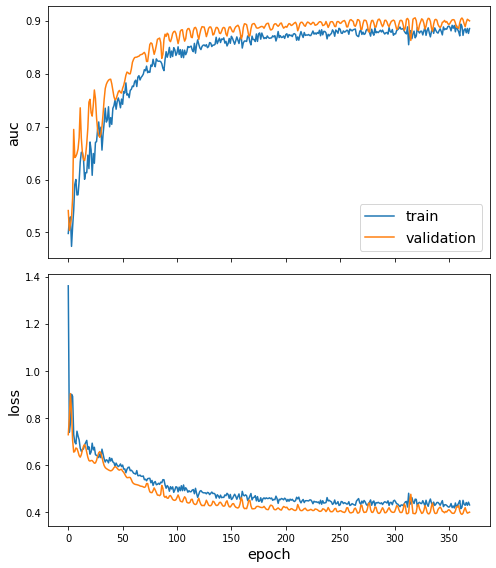

In [33]:

sg.utils.plot_history(history)

In [34]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [35]:
# model.load_weights("logs_copy2/best_model.h5")

In [36]:
train_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 44ms/step - loss: 0.3795 - auc: 0.9128

Test Set Metrics:
	loss: 0.3795
	auc: 0.9128


In [37]:
val_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 47ms/step - loss: 0.3995 - auc: 0.8995

Test Set Metrics:
	loss: 0.3995
	auc: 0.8995


In [38]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 42ms/step - loss: 0.4198 - auc: 0.8910

Test Set Metrics:
	loss: 0.4198
	auc: 0.8910


In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [40]:
fpr, tpr, thres = roc_curve(test_targets[:,0],model.predict(test_gen)[0][:,0])
print (auc(fpr, tpr))

0.887574905870499


In [41]:
import matplotlib.pyplot as plt

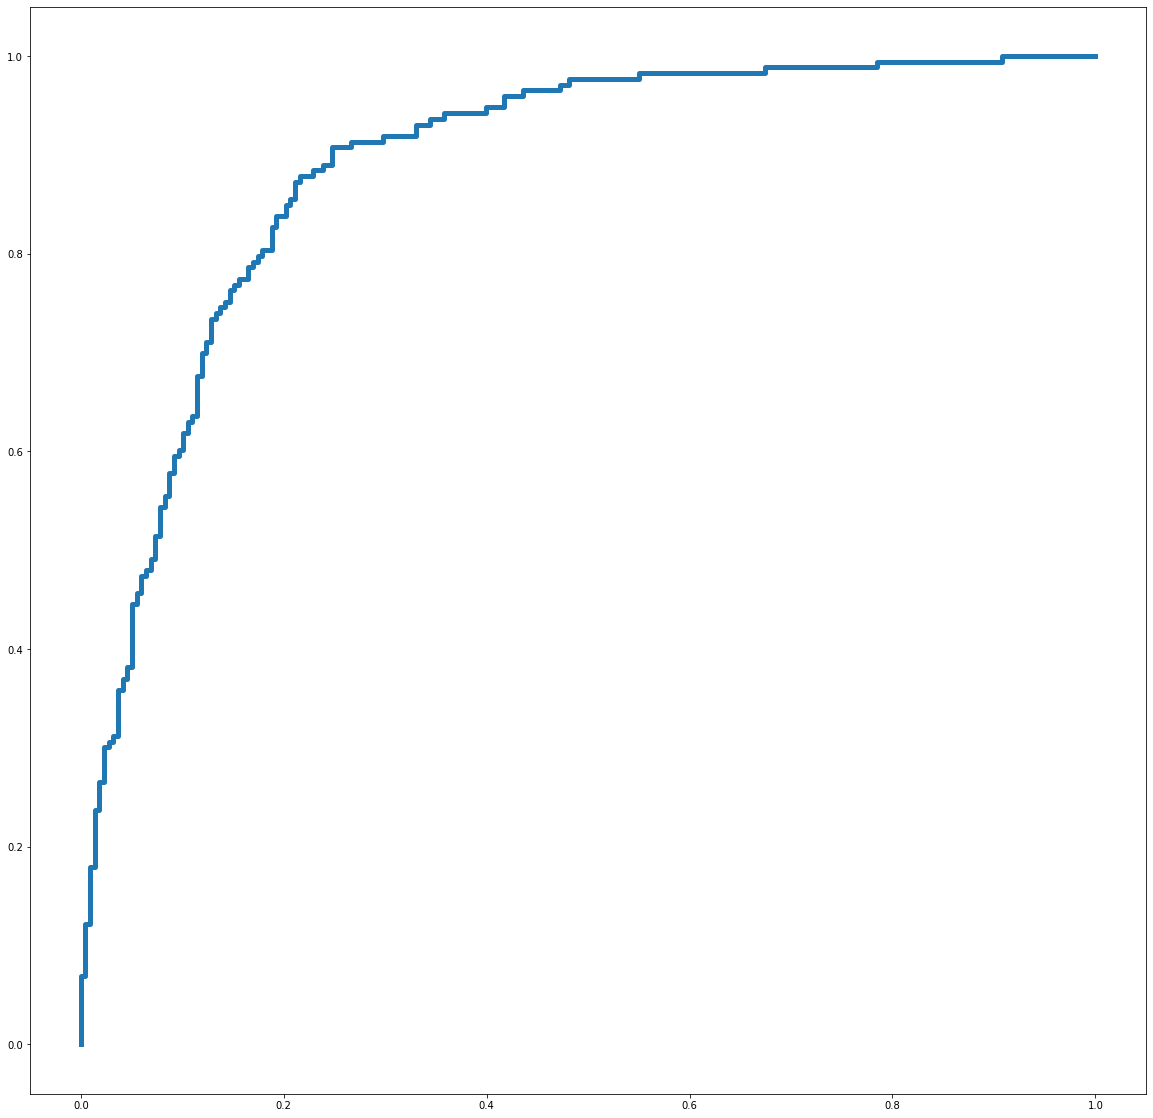

In [42]:
fig=plt.figure(figsize=(20, 20))
plt.plot(fpr, tpr, lw=5, label = "AUROC = {:.2f}".format(auc(fpr, tpr)))